In [ ]:
"""
this notebook is jsut to get familiar with DINO
"""

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoImageProcessor
import matplotlib.pyplot as plt
import os, sys
import math
sys.path.append(os.path.abspath(".."))  # allow relative imports if needed
print(os.path.abspath(".."))

from data.utils.dataloaders import get_imagenet_dataloader

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/BS/data_mani_compress/work/thesis/thesis


In [49]:
class DINOv2FeatureLoss(nn.Module):
    """
    DINOv2FeatureLoss
    ------------------
    Computes a feature-based (semantic) loss between two batches of images
    using pretrained DINOv2 embeddings.

    This loss captures *semantic* similarity — i.e., how similar the images
    are in DINOv2's learned feature space — rather than just pixel-level
    similarity.

    The model uses cosine similarity (recommended) or optionally L1/MSE.
    """

    def __init__(self,
                 dinov2_dir: str,          # local directory with the DINOv2 weights
                 use_pooler=True,          # if True, use pooler_output (CLS after projection)
                 normalize=True,           # whether to L2-normalize embeddings
                 loss_type="cosine",       # 'cosine', 'mse', or 'l1'
                 device=None):             # GPU/CPU selection
        super().__init__()

        # ---------------------------------------------------------------------
        # 1) Load pretrained model and preprocessor from local folder
        # ---------------------------------------------------------------------
        # AutoImageProcessor: handles preprocessing (resize, crop, normalize)
        # AutoModel: loads the transformer backbone itself (ViT trained with DINOv2)
        self.processor = AutoImageProcessor.from_pretrained(
            dinov2_dir, local_files_only=True
        )
        self.model = AutoModel.from_pretrained(
            dinov2_dir, local_files_only=True
        )

        # Set model to evaluation mode (important: disables dropout, etc.)
        self.model.eval()

        # Freeze all parameters (no gradient updates)
        for p in self.model.parameters():
            p.requires_grad = False

        # Store settings
        self.normalize = normalize
        self.loss_type = loss_type
        self.use_pooler = use_pooler

        # Pick the compute device
        # If no device was passed, prefer GPU if available
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Move model to chosen device
        self.model.to(self.device)

    # -------------------------------------------------------------------------
    # 2) Embedding extractor
    # -------------------------------------------------------------------------
    def _embed(self, x01):
        """
        Computes DINOv2 embeddings for a batch of images.

        Args:
            x01 : torch.Tensor [B, 3, H, W]
                RGB images in [0, 1] range.

        Returns:
            emb : torch.Tensor [B, D]
                Feature embeddings for each image (D=768 for DINOv2-Base).
        """

        # The DINOv2 processor expects a *list* of images (not a single batch tensor)
        # Each image can be a tensor, numpy array, or PIL Image.
        # 'do_rescale=False' -> we already have values in [0,1], not [0,255].
        inputs = self.processor(
            images=[t for t in x01],   # convert batch tensor -> list of images
            return_tensors="pt",       # output PyTorch tensors
            do_rescale=False           # skip scaling 0–255 → 0–1
        )

        # Move the resulting tensors to GPU/CPU
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Disable gradient computation (faster + no memory overhead)
        with torch.no_grad():
            # Forward pass through DINOv2 model
            # Output is a dict-like object with keys such as:
            #   'last_hidden_state': [B, num_tokens, D]
            #   'pooler_output'    : [B, D] (optional projection of CLS token)
            out = self.model(**inputs)

        # ---------------------------------------------------------------------
        # Extract embeddings
        # ---------------------------------------------------------------------
        # DINOv2 outputs two useful representations:
        #   - out.last_hidden_state[:, 0]  -> CLS token (global feature)
        #   - out.pooler_output             -> projected CLS (after linear+tanh)
        # The pooler output is typically more stable for similarity comparisons.
        emb = (
            out.pooler_output
            if self.use_pooler and getattr(out, "pooler_output", None) is not None
            else out.last_hidden_state[:, 0]
        )

        # Optional: L2-normalize embeddings so that each vector has unit length.
        # This makes comparisons focus purely on direction (semantic content)
        # instead of magnitude (feature scale).
        if self.normalize:
            emb = F.normalize(emb, p=2, dim=1)

        # Shape: [B, D]
        return emb

    # -------------------------------------------------------------------------
    # 3) Forward: compute the loss between two image batches
    # -------------------------------------------------------------------------
    def forward(self, x01, y01):
        """
        Compute DINOv2 feature loss between two batches of images.

        Args:
            x01 : torch.Tensor [B, 3, H, W]
                First batch (e.g., original images) in [0,1].
            y01 : torch.Tensor [B, 3, H, W]
                Second batch (e.g., reconstructed images) in [0,1].

        Returns:
            loss : torch.ScalarTensor
                Feature-space distance between x and y.
        """

        # Extract embeddings for both sets of images
        fx = self._embed(x01)
        fy = self._embed(y01)

        # ---------------------------------------------------------------------
        # Choose loss type
        # ---------------------------------------------------------------------

        # 1️⃣ Mean Squared Error — penalizes both direction and magnitude differences.
        #    Use if you're doing *feature regression* (not just semantic similarity).
        if self.loss_type == "mse":
            return F.mse_loss(fx, fy)

        # 2️⃣ L1 (Mean Absolute Error) — less sensitive to outliers.
        #    Also includes magnitude information.
        if self.loss_type == "l1":
            return F.l1_loss(fx, fy)

        # 3️⃣ Cosine distance — focuses only on *directional similarity* of features.
        #    This is the correct choice for semantic similarity (DINO embeddings
        #    were trained on normalized features, so scale has no meaning).
        #    The output is in [0, 2] range (0 = identical, 1 = orthogonal).
        return (1 - F.cosine_similarity(fx, fy, dim=1))


In [ ]:
# load original imagenet and reconstructed images
imagenet_reconstructed_2_dataloader = get_imagenet_dataloader(root="/BS/data_mani_compress/work/thesis/imagenet_reconstructed/reconst_2", split="", batch_size=4, shuffle=False, num_workers=2)
imagenet_reconstructed_128_dataloader = get_imagenet_dataloader(root="/BS/data_mani_compress/work/thesis/imagenet_reconstructed/reconst_128", split="", batch_size=4, shuffle=False, num_workers=2)
imagenet_original_dataloader = get_imagenet_dataloader(split="train", batch_size=4, shuffle=False, num_workers=2)


In [43]:
imagenet_original_dataloader = get_imagenet_dataloader(split="train", batch_size=4, shuffle=False, num_workers=2)


In [53]:
dino_loss = DINOv2FeatureLoss(dinov2_dir="/BS/data_mani_compress/work/thesis/thesis/models/weights/dinov2-base", use_pooler=True, normalize=True, loss_type="cosine")

In [6]:
# find the size of the model
total_params = sum(p.numel() for p in dino_loss.model.parameters())
print(f"DINO model has {total_params / 1e6:.2f} million parameters.") 

DINO model has 86.58 million parameters.


In [44]:
# get the first batch
original_images = next(iter(imagenet_original_dataloader))[0]
reconstructed_2_images = next(iter(imagenet_reconstructed_2_dataloader))[0]
reconstructed_128_images = next(iter(imagenet_reconstructed_128_dataloader))[0]

In [45]:
# unnormalize imagenet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
mean = torch.tensor(IMAGENET_MEAN).view(1, 3, 1, 1)
std = torch.tensor(IMAGENET_STD).view(1, 3, 1, 1)
original_images_unnormalized = original_images * std + mean
reconstructed_2_images_unnormalized = reconstructed_2_images * std + mean
reconstructed_128_images_unnormalized = reconstructed_128_images * std + mean

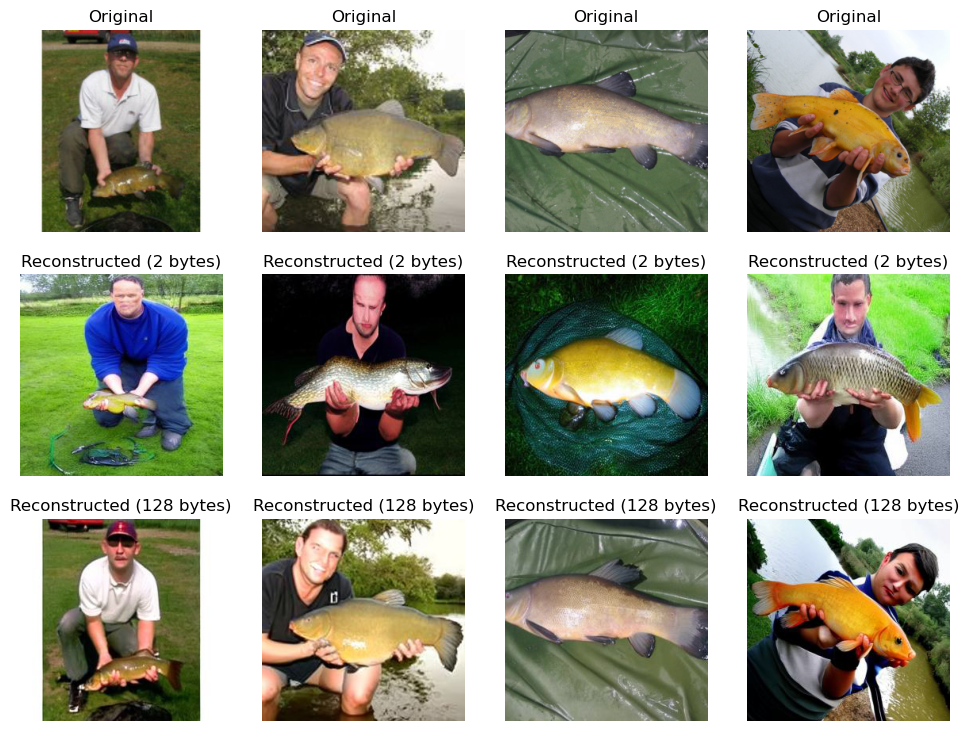

In [46]:
# plot the images using matplotlib
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
for i in range(4):
    axs[0, i].imshow(original_images_unnormalized[i].permute(1, 2, 0).clamp(0, 1))
    axs[0, i].axis('off')
    axs[0, i].set_title('Original')

    axs[1, i].imshow(reconstructed_2_images_unnormalized[i].permute(1, 2, 0).clamp(0, 1))
    axs[1, i].axis('off')
    axs[1, i].set_title('Reconstructed (2 bytes)')

    axs[2, i].imshow(reconstructed_128_images_unnormalized[i].permute(1, 2, 0).clamp(0, 1))
    axs[2, i].axis('off')
    axs[2, i].set_title('Reconstructed (128 bytes)')

In [54]:
semantic_loss_2 = dino_loss(original_images_unnormalized, reconstructed_2_images_unnormalized)
semantic_loss_128 = dino_loss(original_images_unnormalized, reconstructed_128_images_unnormalized)

In [56]:
print(semantic_loss_2.mean(), semantic_loss_128.mean())

tensor(0.4356, device='cuda:0') tensor(0.1403, device='cuda:0')
